In [16]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [17]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])
true_w

array([ 5. ,  1.2, -3.4,  5.6,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ])

In [18]:
features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
poly_features

array([[ 1.00000000e+00,  9.57497508e-01,  9.16801477e-01, ...,
         4.77903364e-01,  4.57591280e-01,  4.38142510e-01],
       [ 1.00000000e+00, -1.95437624e-01,  3.81958647e-02, ...,
        -8.85398835e-13,  1.73040244e-13, -3.38185742e-14],
       [ 1.00000000e+00,  6.53286199e-02,  4.26782858e-03, ...,
         7.19050219e-21,  4.69745585e-22,  3.06878308e-23],
       ...,
       [ 1.00000000e+00,  7.94014368e-01,  6.30458817e-01, ...,
         1.98190185e-02,  1.57365855e-02,  1.24950750e-02],
       [ 1.00000000e+00,  1.31287686e+00,  1.72364565e+00, ...,
         1.02284043e+02,  1.34286353e+02,  1.76301445e+02],
       [ 1.00000000e+00,  1.18327857e+00,  1.40014818e+00, ...,
         1.74774880e+01,  2.06807371e+01,  2.44710731e+01]])

In [19]:
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
lables = np.dot(poly_features, true_w)
lables += np.random.normal(scale=0.1, size=lables.shape)

In [20]:
true_w, features, poly_features, lables = [
    torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, lables]
]
features[:2], poly_features[:2, :], lables[:2]

(tensor([[ 0.9575],
         [-0.1954]]),
 tensor([[ 1.0000e+00,  9.5750e-01,  4.5840e-01,  1.4631e-01,  3.5022e-02,
           6.7067e-03,  1.0703e-03,  1.4640e-04,  1.7522e-05,  1.8641e-06,
           1.7849e-07,  1.5537e-08,  1.2397e-09,  9.1308e-11,  6.2448e-12,
           3.9863e-13,  2.3855e-14,  1.3436e-15,  7.1472e-17,  3.6018e-18],
         [ 1.0000e+00, -1.9544e-01,  1.9098e-02, -1.2442e-03,  6.0789e-05,
          -2.3761e-06,  7.7396e-08, -2.1609e-09,  5.2789e-11, -1.1463e-12,
           2.2404e-14, -3.9805e-16,  6.4828e-18, -9.7460e-20,  1.3605e-21,
          -1.7726e-23,  2.1653e-25, -2.4893e-27,  2.7028e-29, -2.7801e-31]]),
 tensor([5.3258, 4.7201]))

In [21]:
def evaluate_loss(net, data_iter, loss):
    #记录 损失的总和，样本数量
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [22]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss),))

    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.988542   1.1960069 -3.386582   5.58597  ]]


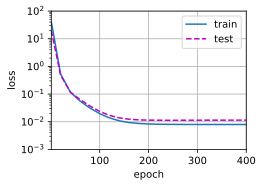

In [23]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      lables[:n_train], lables[n_train:])

weight: [[3.1407444 6.3291364]]


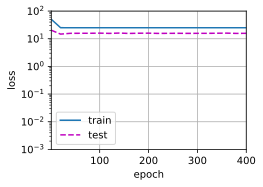

In [25]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      lables[:n_train], lables[n_train:])

weight: [[ 4.9896092   1.2182512  -3.395524    5.4324937  -0.02492107  0.58242744
   0.5202241  -0.29252166  0.02996808 -0.03074199 -0.040613    0.16409925
   0.19913644 -0.01114427  0.20919265  0.09782764 -0.11791066 -0.14607623
   0.18173164  0.1564424 ]]


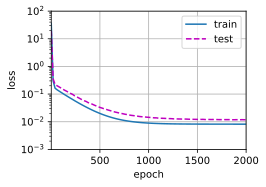

In [26]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      lables[:n_train], lables[n_train:], num_epochs=2000)